In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# 外皮情報LV1からLV2へのコンバート

## 1. 外皮簡易法＋用途別床面積
- 当該住戸の外皮の部位の面積等を用いずに簡易熱負荷計算を実施する場合には、部位の面積および長さを、「平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）」２．エネルギー消費性能の算定方法　2.2　算定方法　第三章　 暖冷房負荷と外皮性能　	第二節　外皮性能　9.当該住戸の外皮の部位の面積等を用いずに外皮性能を評価する方法　に示された標準住戸（以下、「簡易外皮入力モデル」）における部位の面積および長さ等より推定する。
- 屋根・天井、外壁、床の構成は、入力値である部位種別の熱貫流率をもとに、部位のU値から壁体構成を決定する方法により決定する。
- 土間床等の外周部の線熱貫流率については、簡易熱負荷計算での扱いに従う
- 開口部の日射熱取得率および外部日除けの取得日射熱補正係数は、それぞれ、季節別に、垂直面日射熱取得率および取得日射熱補正係数の入力値もしくは規定値を使用する。この場合、簡易熱負荷計算においては、開口部の入射角特性および外部日除けは考慮しない。
- その他は、外皮性能計算プログラムの入力情報に用途別床面積を追加したものと同様に求める。

##### 四捨五入を行う関数

- PythonのRound関数は最近接偶数への丸めとなるため、四捨五入を行う関数を独自に定義する。

In [2]:
def round_number(num, digit) :
    power = 10 ** digit           #10のべき乗
    sign = math.copysign(1, num)  #符号
    return math.floor(sign * power * num + 0.5 ) / ( sign * power ) 

###### Example

In [3]:
round_number(-0.347500, 3)

-0.348

### 2) 面積関係の計算

設計住戸の各部位の長さおよび面積の推定  

$$ A_{i,d}= A_{i,s}・\frac{A_{floor,d}}{A_{floor,s}} $$
$$ L_{i,d}= L_{i,s}・\frac{A_{floor,d}}{A_{floor,s}} $$

$A_{i,d}$: 設計住戸の部位(一般部位又は開口部)$i$の面積の推定値, m<sup>2</sup>  
$L_{i,d}$: 設計住戸の部位(土間床等の外周部)$i$の長さの推定値, m
$A_{floor,s}$: 簡易外皮入力モデル住戸の延床面積, m<sup>2</sup>  
$A_{floor,d}$: 設計住戸の延床面積, m<sup>2</sup>  
$A_{i,s}$: 簡易外皮入力モデル住戸の部位(一般部位又は開口部)$i$の面積, m<sup>2</sup>  
$L_{i,s}$: 簡易外皮入力モデル住戸の部位(土間床等の外周部)$i$の長さ, m  

#### Function

In [4]:
def get_design_parts_area(parts_area_standard, total_floor_area_design):
    TOTAL_FLOOR_AREA_STANDARD = 90.0  #簡易外皮入力モデル住戸の延床面積(m2)
    partsArea = round_number( parts_area_standard * total_floor_area_design / TOTAL_FLOOR_AREA_STANDARD, 2 )
    return partsArea

#### Example

In [5]:
get_design_parts_area(50.85,120)

67.8

## 2. Convert

### 1) Common / 共通

#### Outline

- 地域の区分、主たる居室の床面積(m<sup>2</sup>)、その他の床面積(m<sup>2</sup>)、床面積の合計(m<sup>2</sup>)の情報は維持する。
- 新たに変数「簡易外皮入力フラグ」を作成し、LV1から生成したLV2情報は必ずTrueとする。

#### Input

参照：InputDataDefinition.ipynb

#### Output

```
{
    'Region'
    'IsSimplifiedInput'
    'MainOccupantRoomFloorArea'
    'OtherOccupantRoomFloorArea'
    'TotalFloorArea'
}
```
参照：InputDataDefinition.ipynb

#### Function

In [6]:
def convert_common(Region, MainOccupantRoomFloorArea, OtherOccupantRoomFloorArea, TotalFloorArea, **kwargs):
    return {
        'Region'                     : Region,
        'IsSimplifiedInput'          : True,
        'MainOccupantRoomFloorArea'  : MainOccupantRoomFloorArea,
        'OtherOccupantRoomFloorArea' : OtherOccupantRoomFloorArea,
        'TotalFloorArea'             : TotalFloorArea
    }

#### Example

In [7]:
convert_common(
    Region = 6,
    MainOccupantRoomFloorArea = 30.0,
    OtherOccupantRoomFloorArea = 60.0,
    TotalFloorArea = 120.0
)

{'Region': 6,
 'IsSimplifiedInput': True,
 'MainOccupantRoomFloorArea': 30.0,
 'OtherOccupantRoomFloorArea': 60.0,
 'TotalFloorArea': 120.0}

### 2) 部位のU値から壁体構成を与える

#### Outline

- 屋根・天井、外壁、床、界壁、界床、界床（天井）の構成は、入力値である部位種別の熱貫流率と極力一致するよう、構造種別に応じ、以下の構成における断熱材の厚さを、0mm以上の範囲で、1mm単位で切り捨てて調整する。
- 熱貫流率の入力値が大きい場合、断熱材の厚さを0mmとしても入力値の熱貫流率を再現できないことがあるが、この場合はその差を許容する。

屋根・天井壁体構成（木造、鉄骨造、その他/不明）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.040 | 0 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| せっこうボード | 0.0095 | 0.22 | 0.043 | 830 |
| Ri | - | - | 0.090 | 0 |

外壁壁体構成（木造、鉄骨造、その他/不明）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.040 | 0 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| せっこうボード | 0.0095 | 0.22 | 0.043 | 830 |
| Ri | - | - | 0.110 | 0 |

床壁体構成（木造、鉄骨造、その他/不明）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.040 | 0 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| 合板 | 0.012 | 0.16 | 0.075 | 720 |
| Ri | - | - | 0.150 | - | - |

界床（天井）壁体構成（木造、鉄骨造、その他/不明）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.090 | 0 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| せっこうボード | 0.0095 | 0.22 | 0.043 | 830 |
| Ri | - | - | 0.090 | 0 |

界壁壁体構成（木造、鉄骨造、その他/不明）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.110 | 0 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| せっこうボード | 0.0095 | 0.22 | 0.043 | 830 |
| Ri | - | - | 0.110 | 0 |


界床壁体構成（木造、鉄骨造）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.150 | 0 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| 合板 | 0.012 | 0.16 | 0.075 | 720 |
| Ri | - | - | 0.150 | - | - |

屋根・天井壁体構成（鉄筋コンクリート造等）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.040 | 0 |
| コンクリート | 0.120 | 1.6 | 0.075 | 2000 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| Ri | - | - | 0.090 | 0 |

外壁壁体構成（鉄筋コンクリート造等）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.040 | 0 |
| コンクリート | 0.120 | 1.6 | 0.075 | 2000 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| Ri | - | - | 0.110 | 0 |

床壁体構成（鉄筋コンクリート造等）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.040 | 0 |
| コンクリート | 0.120 | 1.6 | 0.075 | 2000 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| Ri | - | - | 0.150 | - | - |

界床（天井）壁体構成（鉄筋コンクリート造等）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.090 | 0 |
| コンクリート | 0.120 | 1.6 | 0.075 | 2000 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| Ri | - | - | 0.090 | 0 |

界壁壁体構成（鉄筋コンクリート造等）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.110 | 0 |
| コンクリート | 0.120 | 1.6 | 0.075 | 2000 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| Ri | - | - | 0.110 | 0 |

界床壁体構成（鉄筋コンクリート造等）

| 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 熱抵抗, m<sup>2</sup>2 k W<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| Ro | - | - | 0.150 | 0 |
| コンクリート | 0.120 | 1.6 | 0.075 | 2000 |
| 住宅用グラスウール断熱材16K相当 | ≧0mm | 0.045 |  | 13 |
| Ri | - | - | 0.150 | - | - |

#### Class

In [8]:
class Material:
    
    def __init__( self, name, thick, cond, spech ):
        self.name   = name
        self.thick  = thick   # thickness, m
        self.cond   = cond    # thermal conductivity, W/mK
        self.spech  = spech   # volumetric specific heat, J/LK
    
    def R( self ):
        return self.thick / self.cond

#### Example

In [9]:
m = Material( 'GPB', 0.0095, 0.22, 830 )

In [10]:
m.name, m.thick, m.cond, m.spech, m.R()

('GPB', 0.0095, 0.22, 830, 0.04318181818181818)

#### Function

In [11]:
def get_gypsum():
    return Material( name = 'GPB', thick = 0.0095, cond = 0.22, spech =  830.0 )

def get_plywood():
    return Material( name = 'PED', thick = 0.012,  cond = 0.16, spech =  720.0 )

def get_concrete():
    return Material( name = 'RC',  thick = 0.120,  cond = 1.60, spech = 2000.0 )

def convert_u_value_to_spec(structure, typeOfPart, U):
    # structure as string : Wood, Steel, RC, Other
    # typeOfPart as string: Ceiling, Wall, Floor, BoundaryCeiling, BoundaryWall, BoundaryFloor
    # U: heat transfer coefficient (W/m2K)
    s = structure
    t = typeOfPart
    R = 1 / U
    
    Ro, Ri = {
        'Ceiling'         : ( 0.040, 0.090 ),
        'Wall'            : ( 0.040, 0.110 ),
        'Floor'           : ( 0.040, 0.150 ),
        'BoundaryCeiling' : ( 0.090, 0.090 ),
        'BoundaryWall'    : ( 0.110, 0.110 ),
        'BoundaryFloor'   : ( 0.150, 0.150 ),
    }[t]
    
    mGypsum   = get_gypsum()
    mPlywood  = get_plywood()
    mConcrete = get_concrete()
    
    ins_name, ins_cond, ins_spech = 'GW16K', 0.045, 13.0
    
    def d( m ):
        return ( math.floor( max(0,( R -( Ro + m.R() + Ri )) * ins_cond ) * 1000 ) ) / 1000
    
    if ( s in ['Wood', 'Steel', 'Other'] ):
        m = {
            'Ceiling'         : mGypsum,
            'Wall'            : mGypsum,
            'Floor'           : mPlywood,
            'BoundaryWall'    : mGypsum,
            'BoundaryFloor'   : mPlywood,
            'BoundaryCeiling' : mGypsum,
        }[t]
        Layer= [ Material( name = ins_name, thick = d(m), cond = ins_cond, spech = ins_spech ), m ]
    elif s == 'RC':
        m = mConcrete
        Layer= [ m, Material( name = ins_name, thick = d(m), cond = ins_cond, spech = ins_spech ) ]    
    else:
        raise ValueError
        
    return Layer

#### Example 1

In [12]:
m = convert_u_value_to_spec( structure = 'Wood', typeOfPart = 'Wall', U = 0.538 )
vars(m[0]), vars(m[1])

({'name': 'GW16K', 'thick': 0.074, 'cond': 0.045, 'spech': 13.0},
 {'name': 'GPB', 'thick': 0.0095, 'cond': 0.22, 'spech': 830.0})

#### Example 2

U値と断熱材厚の関係のグラフ作成

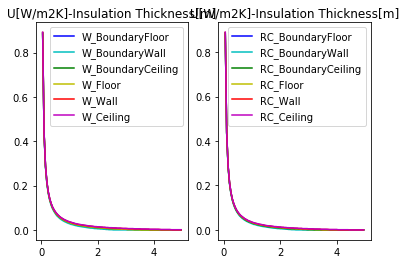

In [13]:
plt.subplot(1, 2, 1)
x=np.arange(0.05,5,0.05)
y=[[],[],[],[],[],[],[]]

wall_type = ['Ceiling','Wall','Floor','BoundaryWall','BoundaryFloor','BoundaryCeiling']

for i in x:
    for j in wall_type:
        temp = convert_u_value_to_spec( 'Wood', j, i )
        #print(wall_type.index(j)) 
        y[wall_type.index(j)].append(temp[0].thick)        
        #print(y[wall_type.index(j)])
        
plt.title(r"U[W/m2K]-Insulation Thickness[m]")
plt.plot(x,y[5],'b',label="W_BoundaryFloor")
plt.plot(x,y[4],'c',label="W_BoundaryWall")
plt.plot(x,y[3],'g',label="W_BoundaryCeiling")
plt.plot(x,y[2],'y',label="W_Floor")
plt.plot(x,y[1],'r',label="W_Wall")
plt.plot(x,y[0],'m',label="W_Ceiling")
plt.legend()

plt.subplot(1, 2, 2)
x=np.arange(0.05,5,0.05)
y=[[],[],[],[],[],[],[]]
for i in x:
    for j in wall_type:
        temp = convert_u_value_to_spec( 'RC' , j, i )
        y[wall_type.index(j)].append(temp[1].thick)        
    
plt.title(r"U[W/m2K]-Insulation Thickness[m]")
plt.plot(x,y[5],'b',label="RC_BoundaryFloor")
plt.plot(x,y[4],'c',label="RC_BoundaryWall")
plt.plot(x,y[3],'g',label="RC_BoundaryCeiling")
plt.plot(x,y[2],'y',label="RC_Floor")
plt.plot(x,y[1],'r',label="RC_Wall")
plt.plot(x,y[0],'m',label="RC_Ceiling")
plt.legend()

plt.show()

### 2) Wall / 開口部以外の不透明部位

#### Outline

- 部位のU値から壁体構成を決定する。
- 簡易外皮入力モデルにおける開口部以外の不透明部位の面積は、壁体種別、方位および断熱構造から決定する。

#### Input

参照：InputDataDefinition.ipynb

#### Output

```
{
    'Name'
    'Type'
    'Structure'
    'Direction'
    'Area'
    'Parts' : [
        {
            AreaRatio
            Layers : [
                {
                    'Name'
                    'Thick'
                    'Cond'
                    'SpecH'
                }
            ]
        ]
}
```

参照：InputDataDefinition.ipynb

#### Function

In [14]:
def make_wall(Name, Type, Structure, Direction, UA, Area, TotalFloorArea):

    #層構成を取得
    layers = convert_u_value_to_spec( Structure, Type, UA )
    part = {
        'AreaRatio': 1.0,
        'Layers'   : [ { 'Name' : l.name, 'Cond' : l.cond, 'Thick' : l.thick, 'SpecH' : l.spech } for l in layers ]
    }

    return {
        'Name'      : Name,
        'Type'      : Type,
        'Structure' : Structure,
        'Direction' : Direction,
        'Area'      : get_design_parts_area( Area , TotalFloorArea ),
        'Parts'     : [part]
    }

def convert_wall(TotalFloorArea, InsulationType, URoof, UWall, UFloor, UDoor, **kwargs):
    
    #簡易外皮入力モデルにおける開口部以外の不透明部位のリストを作成
    standard_parts = {
        'FloorIns': [
            { 'Name': 'Ceiling', 'Type': 'Ceiling', 'Structure': 'Wood', 'Direction': 'Top',    'UA': URoof,  'Area': 50.85 },
            { 'Name': 'Wall_SW', 'Type': 'Wall',    'Structure': 'Wood', 'Direction': 'SW',     'UA': UWall,  'Area': 30.47 },
            { 'Name': 'Wall_NW', 'Type': 'Wall',    'Structure': 'Wood', 'Direction': 'NW',     'UA': UWall,  'Area': 22.37 },
            { 'Name': 'Wall_NE', 'Type': 'Wall',    'Structure': 'Wood', 'Direction': 'NE',     'UA': UWall,  'Area': 47.92 },
            { 'Name': 'Wall_SE', 'Type': 'Wall',    'Structure': 'Wood', 'Direction': 'SE',     'UA': UWall,  'Area': 22.28 },
            { 'Name': 'Floor',   'Type': 'Floor',   'Structure': 'Wood', 'Direction': 'Bottom', 'UA': UFloor, 'Area': 45.05 }
        ],
        'BaseIns': [
            { 'Name': 'Ceiling', 'Type': 'Ceiling', 'Structure': 'Wood', 'Direction': 'Top',    'UA': URoof,  'Area': 50.85 },
            { 'Name': 'Wall_SW', 'Type': 'Wall',    'Structure': 'Wood', 'Direction': 'SW',     'UA': UWall,  'Area': 30.47 },
            { 'Name': 'Wall_NW', 'Type': 'Wall',    'Structure': 'Wood', 'Direction': 'NW',     'UA': UWall,  'Area': 22.37 },
            { 'Name': 'Wall_NE', 'Type': 'Wall',    'Structure': 'Wood', 'Direction': 'NE',     'UA': UWall,  'Area': 47.92 },
            { 'Name': 'Wall_SE', 'Type': 'Wall',    'Structure': 'Wood', 'Direction': 'SE',     'UA': UWall,  'Area': 22.28 },
            { 'Name': 'Floor',   'Type': 'Floor',   'Structure': 'Wood', 'Direction': 'Bottom', 'UA': UFloor, 'Area': 0.00 }
        ]
    }[InsulationType]
    
    return [ make_wall(TotalFloorArea = TotalFloorArea, **f) for f in standard_parts ]

#### Example

In [15]:
convert_wall(
    TotalFloorArea = 120.0,
    InsulationType = 'FloorIns',
    URoof = 7.7,
    UWall = 6.67,
    UFloor = 5.27,
    UDoor = 4.65,
)

[{'Name': 'Ceiling',
  'Type': 'Ceiling',
  'Structure': 'Wood',
  'Direction': 'Top',
  'Area': 67.8,
  'Parts': [{'AreaRatio': 1.0,
    'Layers': [{'Name': 'GW16K', 'Cond': 0.045, 'Thick': 0.0, 'SpecH': 13.0},
     {'Name': 'GPB', 'Cond': 0.22, 'Thick': 0.0095, 'SpecH': 830.0}]}]},
 {'Name': 'Wall_SW',
  'Type': 'Wall',
  'Structure': 'Wood',
  'Direction': 'SW',
  'Area': 40.63,
  'Parts': [{'AreaRatio': 1.0,
    'Layers': [{'Name': 'GW16K', 'Cond': 0.045, 'Thick': 0.0, 'SpecH': 13.0},
     {'Name': 'GPB', 'Cond': 0.22, 'Thick': 0.0095, 'SpecH': 830.0}]}]},
 {'Name': 'Wall_NW',
  'Type': 'Wall',
  'Structure': 'Wood',
  'Direction': 'NW',
  'Area': 29.83,
  'Parts': [{'AreaRatio': 1.0,
    'Layers': [{'Name': 'GW16K', 'Cond': 0.045, 'Thick': 0.0, 'SpecH': 13.0},
     {'Name': 'GPB', 'Cond': 0.22, 'Thick': 0.0095, 'SpecH': 830.0}]}]},
 {'Name': 'Wall_NE',
  'Type': 'Wall',
  'Structure': 'Wood',
  'Direction': 'NE',
  'Area': 63.89,
  'Parts': [{'AreaRatio': 1.0,
    'Layers': [{'Nam

### 3) 日よけの計算

#### Outline

- 取得日射熱補正係数、地域区分、方位、開口部高さ、窓上端と外部日除けの距離から出巾を計算する関数を定義する。
- 取得日射熱補正係数を求める次式を出巾$z$について求める。式中の係数$a$,$b$,$c$,$d$は、地域の区分及び方位により、表1および表2に示す値による。
- 方位は簡易外皮入力モデルの４方位（南東、南西、北西、北東）で固定とする。
- 出巾$z$の上限は5mとする。

$$
f = a \times \left( b + c \times \frac{ d \times y_{1} + y_{2} }{ z } \right)
$$

$f$: 取得日射熱補正係数, -  
$y_{1}$: 日除け下端から窓上端までの垂直方向の距離, m  
$y_{2}$: 窓の開口高さ, m  
$z$: 壁面からの日除けの出巾, m

- 表1 取得日射熱補正係数を求める式の係数（暖房期）

| 季節 | 地域区分 | 方位 | a | b | c | d |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 暖房期 | 1地域～7地域 | 南東(SE) | 0.01 | 5 | 20 | 3 |
| 暖房期 | 1地域～7地域 | 南西(SW) | 0.01 | 5 | 20 | 3 |
| 暖房期 | 1地域～7地域 | 北西(NW) | 0.01 | 10 | 15 | 2 |
| 暖房期 | 1地域～7地域 | 北東(NE) | 0.01 | 10 | 15 | 2 |

- 表2 取得日射熱補正係数を求める式の係数（冷房期）

| 季節 | 地域区分 | 方位 | a | b | c | d |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 冷房期 | 1地域～7地域 | 南東(SE) | 0.01 | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 南西(SW) | 0.01 | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 北西(NW) | 0.01 | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 北東(NE) | 0.01 | 16 | 24 | 2 |
| 冷房期 | 8地域 | 南東(SE) | 0.01 | 16 | 19 | 2 |
| 冷房期 | 8地域 | 南西(SW) | 0.01 | 16 | 19 | 2 |
| 冷房期 | 8地域 | 北西(NW) | 0.01 | 16 | 24 | 2 |
| 冷房期 | 8地域 | 北東(NE) | 0.01 | 16 | 24 | 2 |

#### Function 1

##### 取得日射熱補正係数を求める式の係数を取得する関数

- 季節（暖房 or 冷房）、地域、方位から取得日射熱補正係数を求める式の係数$a,b,c,d$を決定する。

In [16]:
# 取得日射熱補正係数を求める式の係数を取得する関数
def get_coefficients( season, region, direction ):
    # 暖房期
    if season == 'heating':
        if region <= 7:
            a, b, c, d = {
                'SE': (0.01, 5, 20, 3),
                'SW': (0.01, 5, 20, 3),
                'NW': (0.01, 10, 15, 2),
                'NE': (0.01, 10, 15, 2)
            }[direction]
        else:
            raise ValueError
        
    # 冷房期
    elif season == 'cooling':
        if region <= 7:
            a, b, c, d = {
                'SE': (0.01, 16, 24, 2),
                'SW': (0.01, 16, 24, 2),
                'NW': (0.01, 16, 24, 2),
                'NE': (0.01, 16, 24, 2)
            }[direction]
        elif region == 8:
            a, b, c, d = {
                'SE': (0.01, 16, 19, 2),
                'SW': (0.01, 16, 19, 2),
                'NW': (0.01, 16, 24, 2),
                'NE': (0.01, 16, 24, 2)
            }[direction]
        else:
            raise ValueError
        
    # 例外処理
    else:
        raise ValueError
        
    return a, b, c, d

#### Function 2

##### 出巾を計算する関数
- 出巾$z$の上限は5mとする。

In [17]:
def calc_overhang_width(a, b, c, d, y1, y2, f):
    max_z = 5.0 # 出巾の最大値を設定
    if ( ( f / a ) - b) <= 0: 
        return max_z # 分母が0以下になる場合は出巾=最大値とする。
    else:
        return min( ( c * ( d * y1 + y2) ) / ( ( f / a ) - b ), max_z )
        # 出巾が最大値以上になる場合は、最大値を上限とする

#### Function 3 (for heating)

##### 暖房期における出巾を計算する関数
- 取得日射熱補正係数の上限は0.72とする。
- 出巾の計算結果は切り上げの処理を行う。
- 8地域では暖房期の出巾が定義されていないため、エラーとする。

In [18]:
def get_overhang_width_for_heating(region, direction, distance, height, f_heating):
    # region as integer: 1 to 7
    # direction as string: NE, SE, SW, NW
    # distance: vertical distance from bottom of sunshade to top of window (m)
    # height: window height (m)
    # f_heating: solar heat correction factor in heating period (-)　暖房期の取得日射熱補正係数

    y1 = distance
    y2 = height
    
    # 取得日射熱補正係数を調整
    f_h = min( f_heating, 0.72 )
    
    # 出巾を計算（暖房期の出巾は切り上げ）
    if region >= 8:
        raise ValueError('8地域は暖房期の出巾は定義されていません')    
    
    a_h, b_h, c_h, d_h = get_coefficients( 'heating', region, direction )
    
    return math.ceil( calc_overhang_width( a_h, b_h, c_h, d_h, y1, y2, f_h ) * 1000 ) / 1000

#### Function 3 (for cooling)

##### 冷房期における出巾を計算する関数
- 取得日射熱補正係数の上限は0.93とする。
- 出巾の計算結果は切り捨ての処理を行う。

In [19]:
def get_overhang_width_for_cooling(region, direction, distance, height, f_cooling):
    # region as integer: 1 to 8
    # direction as string: NE, SE, SW, NW
    # distance: vertical distance from bottom of sunshade to top of window (m)
    # height: window height (m)
    # f_cooling: solar heat correction factor in heating period (-)　冷房期の取得日射熱補正係数

    y1 = distance
    y2 = height
    
    # 取得日射熱補正係数を調整
    f_c = min( f_cooling, 0.93 )
    
    # 出巾を計算（冷房期の出巾は切り捨て）
    a_c, b_c, c_c, d_c = get_coefficients( 'cooling', region, direction )
    
    return math.floor( calc_overhang_width( a_c, b_c, c_c, d_c, y1, y2, f_c ) * 1000 ) / 1000

#### Example 1

In [20]:
# 暖房期
get_overhang_width_for_heating(6, 'NE', 0, 1.1, 0.7)

0.275

In [21]:
# 冷房期
get_overhang_width_for_cooling(6, 'NE', 0, 1.1, 0.7)

0.488

#### Example 2

##### 取得日射熱補正係数と日除けの出巾のグラフ描画

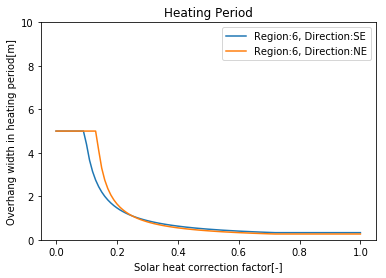

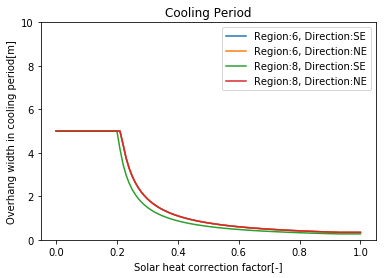

In [22]:
# 取得日射熱補正係数の配列を用意
coefficients = np.arange( 0.0, 1.01, 0.01 )

windows = [
    {'region': 6, 'direction': 'SE'},
    {'region': 6, 'direction': 'NE'},
    {'region': 8, 'direction': 'SE'},
    {'region': 8, 'direction': 'NE'}
]

# 暖房期の高階関数（他の関数を引数または戻り値とする関数）を定義
def makeFFunction_forHeating(region, direction, y1, y2):
    def returnFunction_forHeating(f):
        return get_overhang_width_for_heating(region, direction, y1, y2, f)
    return returnFunction_forHeating
    
# 暖房期の出巾のグラフ描画 
for window in windows:
    if window['region'] >= 8:
        continue
    else:
        g_h = makeFFunction_forHeating(window['region'], window['direction'], 0, 1.1)
        z_h = np.vectorize(g_h)(coefficients)
        label =  'Region:' + str(window['region']) + ', Direction:' + window['direction']
        plt.plot( coefficients, z_h, label = label)
    
plt.title('Heating Period')
plt.xlabel('Solar heat correction factor[-]')
plt.ylabel('Overhang width in heating period[m]')
plt.ylim(0,10)
plt.legend()
plt.show()

# 冷房期の高階関数を定義
def makeFFunction_forCooling(region, direction, y1, y2):
    def returnFunction_forCooling(f):
        return get_overhang_width_for_cooling(region, direction, y1, y2, f)
    return returnFunction_forCooling

# 冷房期の出巾のグラフ描画 
for window in windows:
    g_c = makeFFunction_forCooling(window['region'], window['direction'], 0, 1.1)
    z_c = np.vectorize(g_c)(coefficients)
    label =  'Region:' + str(window['region']) + ', Direction:' + window['direction']
    plt.plot( coefficients, z_c, label = label)
    
plt.title('Cooling Period')
plt.xlabel('Solar heat correction factor[-]')
plt.ylabel('Overhang width in cooling period[m]')
plt.ylim(0,10)
plt.legend()
plt.show()

### 4) Windows / 開口部の透明部位

#### Outline

開口部名称、日射熱取得率(-)、熱貫流率(W/(m<sup>2</sup>・K))の情報は維持する。  
簡易外皮入力モデルにおける開口部の透明部位の面積は、方位から決定する。

#### Input

参照：InputDataDefinition.ipynb

#### Output

```
{
    'Name'
    'Direction'
    'Area'
    'Type'
    'EtaCooling'
    'EtaHeating'
    'UW'
    'IsSunshadeInput'
    'Y2'
    'Z'
    'Y1'
}
```

参照：InputDataDefinition.ipynb

#### Function

In [23]:
def make_window(Name, Direction, Area, TotalFloorArea, EtaDC, EtaDH, UWnd, Region, 
                IsInputFValue = False, FValueC = None, FValueH = None, y1 = None, y2 = None, **kwargs):

    window = {
        'Name'       : Name,
        'Direction'  : Direction,
        'Area'       : get_design_parts_area( Area , TotalFloorArea ),
        'TypeWindow' : 'Single',
        'etaCooling' : EtaDC,
        'etaHeating' : EtaDH,
        'UW'         : UWnd,
    }

    # 日除けの設定
    if IsInputFValue == True :
        window['IsSunshadeInput'] = True
        window['Y1'] = y1
        window['Y2'] = y2

        if Region < 8:
            z_h = get_overhang_width_for_heating( Region, Direction, y1, y2, FValueH )
            z_c = get_overhang_width_for_cooling( Region, Direction, y1, y2, FValueC )
            window['z'] = round_number( ( z_h + z_c ) / 2 , 3 )
        else:
            z_c = get_overhang_width_for_cooling( Region, Direction, y1, y2, FValueC )
            window['z'] = z_c

    else :
        window['IsSunshadeInput'] = False

    return window

def convert_window( TotalFloorArea, EtaDC, EtaDH, UWnd, Region, FValueC, FValueH, **kwargs ):
    
    #簡易外皮入力モデルにおける開口部の透明部位のリストを作成
    standard_parts = [
        {'Name':'WindowSW', 'Direction':'SW', 'Area': 22.69 },
        {'Name':'WindowNW', 'Direction':'NW', 'Area':  2.38 },
        {'Name':'WindowNE', 'Direction':'NE', 'Area':  3.63 },
        {'Name':'WindowSE', 'Direction':'SE', 'Area':  4.37 }
    ]
    
    # 簡易外皮入力モデルにおける日除けの寸法を設定
    y1 = 0    # 窓上端と外部日除けの距離(m)   
    y2 = 1.1  # 開口部高さ(m), 腰高窓を想定
    
    return [ make_window(
                TotalFloorArea = TotalFloorArea,
                EtaDC = EtaDC,
                EtaDH = EtaDH,
                UWnd = UWnd,
                Region = Region,
                FValueC = FValueC, 
                FValueH = FValueH,
                y1 = y1,
                y2 = y2,
                **f) 
            for f in standard_parts]

#### Example

In [24]:
convert_window(
    Region = 6,
    MainOccupantRoomFloorArea = 30.0,
    OtherOccupantRoomFloorArea = 60.0,
    TotalFloorArea = 120.0,
    UWnd = 3.49,
    EtaDC = 0.51,       
    EtaDH = 0.51, 
    IsInputFValue = True, 
    FValueC = 0.9,
    FValueH = 0.7
)

[{'Name': 'WindowSW',
  'Direction': 'SW',
  'Area': 30.25,
  'TypeWindow': 'Single',
  'etaCooling': 0.51,
  'etaHeating': 0.51,
  'UW': 3.49,
  'IsSunshadeInput': False},
 {'Name': 'WindowNW',
  'Direction': 'NW',
  'Area': 3.17,
  'TypeWindow': 'Single',
  'etaCooling': 0.51,
  'etaHeating': 0.51,
  'UW': 3.49,
  'IsSunshadeInput': False},
 {'Name': 'WindowNE',
  'Direction': 'NE',
  'Area': 4.84,
  'TypeWindow': 'Single',
  'etaCooling': 0.51,
  'etaHeating': 0.51,
  'UW': 3.49,
  'IsSunshadeInput': False},
 {'Name': 'WindowSE',
  'Direction': 'SE',
  'Area': 5.83,
  'TypeWindow': 'Single',
  'etaCooling': 0.51,
  'etaHeating': 0.51,
  'UW': 3.49,
  'IsSunshadeInput': False}]

### 4) Doors / 開口部の不透明部位

#### Outline

- 開口部の不透明部位（ドア等）の情報を設定する。
- 簡易外皮入力モデルにおける開口部の不透明部位の面積は、方位から決定する。

#### Input

参照：InputDataDefinition.ipynb

#### Output

```
{
    'Name'
    'Direction'
    'Area'
    'U'
    'IsSunshadeInput'
}
```


参照：InputDataDefinition.ipynb

#### Function

In [25]:
def make_door(Name, Direction, Area, TotalFloorArea, UDoor):
    return {
        'Name'           : Name,
        'Direction'      : Direction,
        'Area'           : get_design_parts_area( Area , TotalFloorArea ),
        'U'              : UDoor,
        'IsSunshadeInput': False
    }

def convert_door(TotalFloorArea, UDoor, **kwargs):
    
    #簡易外皮入力モデルにおける開口部の不透明部位のリストを作成
    standard_parts = [
        {'Name': 'DoorNW', 'Direction':'NW', 'Area': 1.89 },
        {'Name': 'DoorNE', 'Direction':'NE', 'Area': 1.62 }
    ]
    
    return [ make_door(TotalFloorArea = TotalFloorArea, UDoor = UDoor, **f) for f in standard_parts ]

#### Example

In [26]:
convert_door(
    TotalFloorArea = 120.0,
    UDoor = 2.33,
)

[{'Name': 'DoorNW',
  'Direction': 'NW',
  'Area': 2.52,
  'U': 2.33,
  'IsSunshadeInput': False},
 {'Name': 'DoorNE',
  'Direction': 'NE',
  'Area': 2.16,
  'U': 2.33,
  'IsSunshadeInput': False}]

### 5) Earth Floor Perimeters / 土間床等の外周部の線熱橋

#### Outline

- 土間床（玄関および玄関以外）の外周部の線熱橋の情報を設定する。

#### Input

参照：InputDataDefinition.ipynb

#### Output

```
data = {
    'Name'
    'Direction'
    'Length'
    'Psi'
}
```

参照：InputDataDefinition.ipynb

#### Function

In [27]:
def make_earth_floor(Name, Direction, Length, Psi, TotalFloorArea):
    # f = standard_earth_floor
    return {
        'Name'      : Name,
        'Direction' : Direction,
        'Length'    : get_design_parts_area( Length , TotalFloorArea ),
        'Psi'       : Psi
    }

def convert_earthfloor_perimeters( InsulationType, TotalFloorArea, IsInputPsiBase = False, PsiBaseOthers = None, PsiBaseEntrance = None, **kawrgs ):
    
    # 線熱貫流率を設定
    psi_other = PsiBaseOthers if IsInputPsiBase == True else 1.8
    psi_entrance = PsiBaseEntrance if IsInputPsiBase == True else 1.8
    
    #簡易外皮入力モデルにおける土間床等の外周部リストを作成
    standard_earth_floors = {
        'FloorIns': [
            { 'Name' : 'Other_NW',       'Direction' : 'NW',            'Length': 1.82, 'Psi': psi_other },
            { 'Name' : 'Other_NE',       'Direction' : 'NE',            'Length': 1.82, 'Psi': psi_other },
            { 'Name' : 'Other_floor',    'Direction' : 'OpenBackFloor', 'Length': 3.64, 'Psi': psi_other },
            { 'Name' : 'Entrance_NW',    'Direction' : 'NW',            'Length': 1.82, 'Psi': psi_entrance },
            { 'Name' : 'Entrance_NE',    'Direction' : 'NE',            'Length': 1.37, 'Psi': psi_entrance },
            { 'Name' : 'Entrance_floor', 'Direction' : 'OpenBackFloor', 'Length': 3.19, 'Psi': psi_entrance }
        ],
        'BaseIns': [
            { 'Name' : 'Other_SW',    'Direction' : 'SW', 'Length': 10.61, 'Psi': psi_other },
            { 'Name' : 'Other_NW',    'Direction' : 'NW', 'Length':  2.97, 'Psi': psi_other },
            { 'Name' : 'Other_NE',    'Direction' : 'NE', 'Length':  9.24, 'Psi': psi_other },
            { 'Name' : 'Other_SE',    'Direction' : 'SE', 'Length':  4.79, 'Psi': psi_other },
            { 'Name' : 'Entrance_NW', 'Direction' : 'NW', 'Length':  1.82, 'Psi': psi_entrance },
            { 'Name' : 'Entrance_NE', 'Direction' : 'NE', 'Length':  1.37, 'Psi': psi_entrance },
        ]
    }[InsulationType]

    return [ make_earth_floor(TotalFloorArea = TotalFloorArea,**f) for f in standard_earth_floors ]

#### Example

In [28]:
convert_earthfloor_perimeters( 
    InsulationType = 'FloorIns',
    TotalFloorArea = 120.0,
    IsInputPsiBase = False
)

[{'Name': 'Other_NW', 'Direction': 'NW', 'Length': 2.43, 'Psi': 1.8},
 {'Name': 'Other_NE', 'Direction': 'NE', 'Length': 2.43, 'Psi': 1.8},
 {'Name': 'Other_floor',
  'Direction': 'OpenBackFloor',
  'Length': 4.85,
  'Psi': 1.8},
 {'Name': 'Entrance_NW', 'Direction': 'NW', 'Length': 2.43, 'Psi': 1.8},
 {'Name': 'Entrance_NE', 'Direction': 'NE', 'Length': 1.83, 'Psi': 1.8},
 {'Name': 'Entrance_floor',
  'Direction': 'OpenBackFloor',
  'Length': 4.25,
  'Psi': 1.8}]

## 3. Lv2入力情報のコンバート（統合）

- 1)共通情報、2)開口部以外の不透明部位、3)開口部の透明部位、4)開口部の不透明部位、5)土間床等の外周部の線熱橋、の各コンバート関数を統合し、Lv1の入力情報をLv2の入力情報にコンバートする。

In [29]:
def convert(d):
    d_common = convert_common(**d)
    d_walls = convert_wall(**d)
    d_windows = convert_window(**d)
    d_doors = convert_door(**d)
    d_perimeters = convert_earthfloor_perimeters(**d)
    return { 
        'Common': d_common,
        'Walls' : d_walls,
        'Windows' : d_windows,
        'Doors' : d_doors,
        'EarthfloorPerimeters' : d_perimeters
    }

### Example

In [30]:
d = {
    'Region' : 6,
    'MainOccupantRoomFloorArea': 30.0,
    'OtherOccupantRoomFloorArea': 60.0,
    'TotalFloorArea': 120.0,
    'InsulationType' : 'FloorIns',
    'URoof' : 7.7,
    'UWall' : 6.67,
    'UFloor' : 5.27,
    'UDoor' : 4.65,
    'UWnd' : 3.49,
    'EtaDC' : 0.51,       
    'EtaDH' : 0.51, 
    'IsInputFValue' : True, 
    'FValueC' : 0.9,
    'FValueH' : 0.7,
    'IsInputPsiBase' : True,
    'PsiBaseOthers' : 1.8,
    'PsiBaseEntrance' :1.8
}

convert(d)

{'Common': {'Region': 6,
  'IsSimplifiedInput': True,
  'MainOccupantRoomFloorArea': 30.0,
  'OtherOccupantRoomFloorArea': 60.0,
  'TotalFloorArea': 120.0},
 'Walls': [{'Name': 'Ceiling',
   'Type': 'Ceiling',
   'Structure': 'Wood',
   'Direction': 'Top',
   'Area': 67.8,
   'Parts': [{'AreaRatio': 1.0,
     'Layers': [{'Name': 'GW16K', 'Cond': 0.045, 'Thick': 0.0, 'SpecH': 13.0},
      {'Name': 'GPB', 'Cond': 0.22, 'Thick': 0.0095, 'SpecH': 830.0}]}]},
  {'Name': 'Wall_SW',
   'Type': 'Wall',
   'Structure': 'Wood',
   'Direction': 'SW',
   'Area': 40.63,
   'Parts': [{'AreaRatio': 1.0,
     'Layers': [{'Name': 'GW16K', 'Cond': 0.045, 'Thick': 0.0, 'SpecH': 13.0},
      {'Name': 'GPB', 'Cond': 0.22, 'Thick': 0.0095, 'SpecH': 830.0}]}]},
  {'Name': 'Wall_NW',
   'Type': 'Wall',
   'Structure': 'Wood',
   'Direction': 'NW',
   'Area': 29.83,
   'Parts': [{'AreaRatio': 1.0,
     'Layers': [{'Name': 'GW16K', 'Cond': 0.045, 'Thick': 0.0, 'SpecH': 13.0},
      {'Name': 'GPB', 'Cond': 0.22,